In [2]:
import os
os.environ["PYTHONHASHSEED"] = "42"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import pandas as pd
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from torchvision import datasets
from torch.autograd.functional import hessian
import torch.nn as nn
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def get_cropped_images(X, y, n):
    """Returns images that can be cropped by n pixels on all sides without
    losing any information (all cropped pixels = 0).

    Args:
        X np.ndarray: Input images.
        y np.ndarray: Corresponding labels.
        n (int): Number of pixels to crop from each side.

    Returns:
        np.ndarray: Cropped images.
    """

    mask = np.zeros((X.shape[1], X.shape[2]), dtype=bool)
    mask[:n, :] = True
    mask[-n:, :] = True
    mask[:, :n] = True
    mask[:, -n:] = True

    border_pixels = X[:, mask]
    croppable_mask = (border_pixels.sum(axis=1) == 0)
    return X[croppable_mask, n:-n, n:-n], y[croppable_mask]


In [5]:
# Preprocessing

# Load MNIST dataset
train = datasets.MNIST(root="./data", train=True,  download=True)
test  = datasets.MNIST(root="./data", train=False, download=True)
X_full = torch.cat([train.data, test.data], dim=0).numpy() / 255.0
y_full = torch.cat([train.targets, test.targets], dim=0).numpy()

# Crop images by n pixels on each side
X_cropped, y_cropped = get_cropped_images(X_full, y_full, 4)
y_cropped = pd.Series(y_cropped)

# Select most frequent classes
num_labels = 7
classes = y_cropped.value_counts().index[:num_labels]

# Create train/test split with 1000 train / 200 test samples per class
X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []

for clss in classes:
    indices = y_cropped[y_cropped == clss].sample(1000, random_state=SEED).index
    X_train_list.append(X_cropped[indices[:800]])
    y_train_list.append(y_cropped[indices[:800]])
    X_test_list.append(X_cropped[indices[800:]])
    y_test_list.append(y_cropped[indices[800:]])

X_train = np.concatenate(X_train_list, axis=0)
y_train = pd.concat(y_train_list, axis=0).reset_index(drop=True)
X_test = np.concatenate(X_test_list, axis=0)
y_test = pd.concat(y_test_list, axis=0).reset_index(drop=True)

# Convert y from image label to class label (see classes variable)
class_map = {clss: idx for idx, clss in enumerate(classes)}
y_train = y_train.map(class_map)
y_test = y_test.map(class_map)

# Shuffle data
shuffle_indices_train = y_train.sample(y_train.shape[0], random_state=SEED).index
shuffle_indices_test = y_test.sample(y_test.shape[0], random_state=SEED).index

X = X_train[shuffle_indices_train]
y = y_train[shuffle_indices_train].reset_index(drop=True).to_numpy()
X_test = X_test[shuffle_indices_test]
y_test = y_test[shuffle_indices_test].reset_index(drop=True).to_numpy()

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32, device=device)
y = torch.tensor(y, dtype=torch.long, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.long, device=device)

In [6]:
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size, num_hidden_layers, hidden_layer_size, 
                 num_labels, activation):
        super(FullyConnectedNet, self).__init__()

        self.input_size = input_size
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layers_size = hidden_layer_size
        self.num_labels = num_labels
        self.activation = activation

        layers = [nn.Flatten()]
        in_size = input_size

        for _ in range(num_hidden_layers):
            layers += [nn.Linear(in_size, hidden_layer_size), activation()]
            in_size = hidden_layer_size

        layers.append(nn.Linear(in_size, num_labels))
        self.network = nn.Sequential(*layers)

            # --- Metadata for flatten/unflatten ---
        params = list(self.parameters())
        self.param_shapes = [p.shape for p in params]
        self.param_sizes  = [p.numel() for p in params]
        self.param_offsets = np.cumsum([0] + self.param_sizes).tolist()
        self.param_list = list(self.parameters())

    def forward(self, x):
        return self.network(x)

    def forward_with_params(self, X, flat_params):
        
        """Forward pass using explicit parameter vector."""
        params = self.unflatten_params(flat_params)
        x = X
        i = 0
        for layer in self.network:
            if isinstance(layer, nn.Flatten):
                x = x.view(x.size(0), -1)
            elif isinstance(layer, nn.Linear):
                w, b = params[i], params[i+1]
                x = F.linear(x, w, b)
                i += 2
            elif isinstance(layer, nn.ReLU):
                x = F.relu(x)
            else:
                raise ValueError(f"Unsupported layer type: {type(layer)}")
        return x

    def unflatten_params(self, flat_params):
        return [
            flat_params[self.param_offsets[i]:self.param_offsets[i+1]].view(self.param_shapes[i])
            for i in range(len(self.param_shapes))
        ]
        
    def flatten_params(self):
        return torch.cat([p.reshape(-1) for p in self.parameters()])

In [7]:
def loss_wrt_params(flat_params, model, criterion, X, y):
    """Compute scalar loss for explicit parameter vector."""
    outputs = model.forward_with_params(X, flat_params)
    return criterion(outputs, y)


def compute_hessian(model, criterion, X, y):
    """Compute full dense Hessian of loss wrt flattened parameters."""
    torch.cuda.empty_cache()
    params_flat = model.flatten_params().detach().clone().requires_grad_(True).to(X.device)
    return torch.autograd.functional.hessian(
        lambda p: loss_wrt_params(p, model, criterion, X, y),
        params_flat,
        vectorize=True
    )

def compute_eig_A(optimizer, H):
    v_t = torch.cat([
        state['square_avg'].flatten()
        for state in optimizer.state.values()
    ]).to(device)
    
    eta = optimizer.param_groups[0]['lr']
    eps = optimizer.param_groups[0]['eps']
    
    eta_eff = eta / torch.sqrt(v_t + eps)
    sqrt_eta = torch.sqrt(eta_eff)
    H_scaled = (H * sqrt_eta).T * sqrt_eta
    return torch.linalg.eigvalsh(H_scaled)  

In [8]:
def setup_output_files(output_dir="output"): 

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    metadata_path = os.path.join(output_dir, "metadata_rmsprop.csv")
    output_data_path = os.path.join(output_dir, "output_rmsprop.csv")

    if os.path.exists(metadata_path):
            metadata = pd.read_csv(metadata_path)
    else:
        metadata = pd.DataFrame({
            "model_id": pd.Series(dtype="int"),
            "model_type": pd.Series(dtype="str"),
            "num_hidden_layers": pd.Series(dtype="int"),
            "hidden_layers_size": pd.Series(dtype="int"),
            "activation_function": pd.Series(dtype="str"),
            "optimizer": pd.Series(dtype="str"),
            "learning_rate": pd.Series(dtype="float"),
            "num_epochs": pd.Series(dtype="int"),
        })

    if os.path.exists(output_data_path):
        output_data = pd.read_csv(output_data_path)
    else:
        output_data = pd.DataFrame({
            "model_id": pd.Series(dtype="int"),
            "epoch": pd.Series(dtype="int"),
            "loss": pd.Series(dtype="float"),
            "sharpness": pd.Series(dtype="float"),
            "rms_limit": pd.Series(dtype="float")
        })

    return metadata, output_data

def load_output_files(output_dir="output"):
    metadata_path = os.path.join(output_dir, "metadata_rmsprop.csv")
    output_data_path = os.path.join(output_dir, "output_rmsprop.csv")

    metadata = pd.read_csv(metadata_path)
    output_data = pd.read_csv(output_data_path)

    return metadata, output_data

def save_output_files(metadata, output_data, output_dir="output"):

    metadata_path = os.path.join(output_dir, "metadata_rmsprop.csv")
    output_data_path = os.path.join(output_dir, "output_rmsprop.csv")

    metadata.to_csv(metadata_path, index=False)
    output_data.to_csv(output_data_path, index=False)

In [9]:
def A_mv(v, model, criterion, X, y, D_sqrt):
    u = D_sqrt * v

    out = model(X)
    loss = criterion(out, y)

    grad = torch.autograd.grad(loss, model.param_list, create_graph=True)
    g_flat = torch.cat([p.reshape(-1) for p in grad])

    Hv = torch.autograd.grad(g_flat @ u, model.param_list, retain_graph=True)
    Hv_flat = torch.cat([h.reshape(-1) for h in Hv])

    return D_sqrt * Hv_flat

def top_eigenpair_A(model, optimizer, criterion, X, y, iters=50):
    # -----------------------------
    # Build RMSProp scaling matrix
    # -----------------------------
    v_t = torch.cat([
        state['square_avg'].flatten()
        for state in optimizer.state.values()
    ]).detach()

    eta = optimizer.param_groups[0]['lr']
    eps = optimizer.param_groups[0]['eps']

    D_sqrt = torch.sqrt(eta / torch.sqrt(v_t + eps))

    # -----------------------------------
    # 1. SINGLE forward and backward pass
    # -----------------------------------
    with torch.enable_grad():
        out = model(X)
        loss = criterion(out, y)

        # gradient WITH graph for Hessian
        grad_list = torch.autograd.grad(
            loss, model.param_list, create_graph=True
        )
        g_flat = torch.cat([g.reshape(-1) for g in grad_list])

    # -----------------------------------
    # Helper: Hessian-vector product Hv
    # -----------------------------------
    def H_mv(u):
        # Compute (∇g_flat · u)
        Hu_list = torch.autograd.grad(
            g_flat @ u,
            model.param_list,
            retain_graph=True
        )
        Hu = torch.cat([h.reshape(-1) for h in Hu_list])
        return Hu

    # -----------------------------------
    # 2. Power iteration
    # -----------------------------------
    v = torch.randn_like(D_sqrt)
    v = v / v.norm()

    for _ in range(iters):
        with torch.enable_grad():
            Hv = H_mv(D_sqrt * v)

        with torch.no_grad():
            Av = D_sqrt * Hv
            v = Av / Av.norm()
            v = v.detach()

    # -----------------------------------
    # 3. Rayleigh quotient λ = vᵀ A v
    # -----------------------------------
    with torch.enable_grad():
        Hv_final = H_mv(D_sqrt * v)
    lambda_max = (v @ (D_sqrt * Hv_final)).item()

    return lambda_max, v

In [10]:
def train_model(model, optimizer, criterion, epochs, X, y):
    learning_rate = optimizer.param_groups[0]['lr']

    model.to(device)
    model.train()

    train_losses = np.empty(epochs)
    sharps = np.empty(epochs)

    start = time.time()

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        train_losses[epoch] = loss.item()

        sharps[epoch] = top_eigenpair_A(model, optimizer, criterion, X, y)[0]
        
        if (epoch+1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, " +
                  f"Time: {round(((time.time() - start) / 60), 2)}")

    metadata, output_data = setup_output_files("output")
    model_id = metadata.shape[0] + 1

    metadata.loc[metadata.shape[0]] ={
        "model_id": model_id,
        "model_type": model.__class__.__name__,
        "num_hidden_layers": model.num_hidden_layers,
        "hidden_layers_size": model.hidden_layers_size,
        "activation_function": model.activation.__name__,
        "optimizer": optimizer.__class__.__name__,
        "learning_rate": learning_rate,
        "num_epochs": epochs,
    }

    output_data = pd.concat([output_data, pd.DataFrame({
        "model_id": np.ones_like(train_losses) * model_id,
        "epoch": np.arange(1, epochs + 1),
        "loss": train_losses,
        "sharpness": sharps,
    })], ignore_index=True)

    save_output_files(metadata, output_data)

In [11]:
input_size = X.shape[1] * X.shape[2] # 400
num_hidden_layers = 2
hidden_layer_size = 21
learning_rates = [0.033, 0.01, 0.0033, 0.001]
epochs = 2000

for learning_rate in learning_rates:

    model = FullyConnectedNet(
        input_size=input_size,
        num_hidden_layers=num_hidden_layers,
        hidden_layer_size=hidden_layer_size,
        num_labels=num_labels,
        activation=nn.ReLU
    )

    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

    criterion = nn.CrossEntropyLoss()

    train_model(model, optimizer, criterion, epochs, X, y)

Epoch [20/2000], Loss: 1.6983, Time: 0.05
Epoch [40/2000], Loss: 1.4679, Time: 0.09
Epoch [60/2000], Loss: 1.1988, Time: 0.13
Epoch [80/2000], Loss: 1.0804, Time: 0.17
Epoch [100/2000], Loss: 0.8677, Time: 0.21
Epoch [120/2000], Loss: 0.7002, Time: 0.24
Epoch [140/2000], Loss: 0.6042, Time: 0.28
Epoch [160/2000], Loss: 0.5924, Time: 0.32
Epoch [180/2000], Loss: 0.5558, Time: 0.36
Epoch [200/2000], Loss: 0.5190, Time: 0.4
Epoch [220/2000], Loss: 0.7031, Time: 0.44
Epoch [240/2000], Loss: 0.7367, Time: 0.47
Epoch [260/2000], Loss: 0.5879, Time: 0.51
Epoch [280/2000], Loss: 0.4953, Time: 0.55
Epoch [300/2000], Loss: 0.5743, Time: 0.59
Epoch [320/2000], Loss: 0.6207, Time: 0.63
Epoch [340/2000], Loss: 0.7901, Time: 0.67
Epoch [360/2000], Loss: 0.5930, Time: 0.7
Epoch [380/2000], Loss: 0.6154, Time: 0.74
Epoch [400/2000], Loss: 0.5159, Time: 0.78
Epoch [420/2000], Loss: 0.6641, Time: 0.82
Epoch [440/2000], Loss: 0.4320, Time: 0.86
Epoch [460/2000], Loss: 0.4224, Time: 0.9
Epoch [480/2000], 

In [ ]:
input_size = X.shape[1] * X.shape[2] # 400
num_hidden_layers = 2
hidden_layer_size = 21
learning_rates = [0.01, 0.0033, 0.001, 0.00033, 0.0001]
epochs = 5000

for learning_rate in learning_rates:

    model = FullyConnectedNet(
        input_size=input_size,
        num_hidden_layers=num_hidden_layers,
        hidden_layer_size=hidden_layer_size,
        num_labels=num_labels,
        activation=nn.ReLU
    )

    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

    criterion = nn.CrossEntropyLoss()

    train_model(model, optimizer, criterion, epochs, X, y)


Epoch [20/5000], Loss: 0.4828, Time: 0.04
Epoch [40/5000], Loss: 0.2400, Time: 0.08
Epoch [60/5000], Loss: 0.1685, Time: 0.12
Epoch [80/5000], Loss: 0.3671, Time: 0.16
Epoch [100/5000], Loss: 0.1189, Time: 0.2
Epoch [120/5000], Loss: 0.1011, Time: 0.24
Epoch [140/5000], Loss: 0.0890, Time: 0.28
Epoch [160/5000], Loss: 0.1106, Time: 0.32
Epoch [180/5000], Loss: 0.0687, Time: 0.36
Epoch [200/5000], Loss: 0.0605, Time: 0.4
Epoch [220/5000], Loss: 0.0477, Time: 0.44
Epoch [240/5000], Loss: 0.0408, Time: 0.48
Epoch [260/5000], Loss: 0.3200, Time: 0.52
Epoch [280/5000], Loss: 0.0421, Time: 0.56
Epoch [300/5000], Loss: 0.0338, Time: 0.6
Epoch [320/5000], Loss: 0.0290, Time: 0.64
Epoch [340/5000], Loss: 0.0252, Time: 0.68
Epoch [360/5000], Loss: 0.0252, Time: 0.72
Epoch [380/5000], Loss: 0.0778, Time: 0.76
Epoch [400/5000], Loss: 0.0462, Time: 0.8
Epoch [420/5000], Loss: 0.0335, Time: 0.84
Epoch [440/5000], Loss: 0.0269, Time: 0.88
Epoch [460/5000], Loss: 0.0227, Time: 0.92
Epoch [480/5000], L

In [36]:
input_size = X.shape[1] * X.shape[2] # 400
num_hidden_layers = 2
hidden_layer_size = 21
learning_rates = [0.01, 0.0033, 0.001, 0.00033, 0.0001, 0.000033]
epochs = 10000

for learning_rate in learning_rates:

    model = FullyConnectedNet(
        input_size=input_size,
        num_hidden_layers=num_hidden_layers,
        hidden_layer_size=hidden_layer_size,
        num_labels=num_labels,
        activation=nn.ReLU
    )

    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

    criterion = nn.CrossEntropyLoss()

    train_model(model, optimizer, criterion, epochs, X, y)

Epoch [20/10000], Loss: 0.7427, Time: 0.05
Epoch [40/10000], Loss: 0.4041, Time: 0.09
Epoch [60/10000], Loss: 0.2615, Time: 0.14
Epoch [80/10000], Loss: 0.2158, Time: 0.19
Epoch [100/10000], Loss: 0.1478, Time: 0.23
Epoch [120/10000], Loss: 0.1210, Time: 0.28
Epoch [140/10000], Loss: 0.1110, Time: 0.33
Epoch [160/10000], Loss: 0.1815, Time: 0.37
Epoch [180/10000], Loss: 0.0809, Time: 0.42
Epoch [200/10000], Loss: 0.0653, Time: 0.47
Epoch [220/10000], Loss: 0.1025, Time: 0.52
Epoch [240/10000], Loss: 0.0532, Time: 0.56
Epoch [260/10000], Loss: 0.0471, Time: 0.61
Epoch [280/10000], Loss: 0.0449, Time: 0.65
Epoch [300/10000], Loss: 0.0352, Time: 0.69
Epoch [320/10000], Loss: 0.1423, Time: 0.73
Epoch [340/10000], Loss: 0.0457, Time: 0.77
Epoch [360/10000], Loss: 0.0359, Time: 0.81
Epoch [380/10000], Loss: 0.0307, Time: 0.85
Epoch [400/10000], Loss: 0.0268, Time: 0.88
Epoch [420/10000], Loss: 0.0236, Time: 0.93
Epoch [440/10000], Loss: 0.0208, Time: 0.97
Epoch [460/10000], Loss: 0.0185, Tim

In [34]:
md, out = load_output_files()
md

model_id         model_type  num_hidden_layers  hidden_layers_size  \
0         1  FullyConnectedNet                  2                  21   
1         2  FullyConnectedNet                  2                  21   
2         3  FullyConnectedNet                  2                  21   
3         4  FullyConnectedNet                  2                  21   
4         5  FullyConnectedNet                  2                  21   
5         6  FullyConnectedNet                  2                  21   
6         7  FullyConnectedNet                  2                  21   
7         8  FullyConnectedNet                  2                  21   
8         9  FullyConnectedNet                  2                  21   

  activation_function optimizer  learning_rate  num_epochs  
0                ReLU   RMSprop        0.03300        2000  
1                ReLU   RMSprop        0.01000        2000  
2                ReLU   RMSprop        0.00330        2000  
3                ReLU   RMSprop        0.00100        2000  
4                ReLU   RMSprop        0.01000        5000  
5                ReLU   RMSprop        0.00330        5000  
6                ReLU   RMSprop        0.00100        5000  
7                ReLU   RMSprop        0.00033        5000  
8                ReLU   RMSprop        0.00010        5000

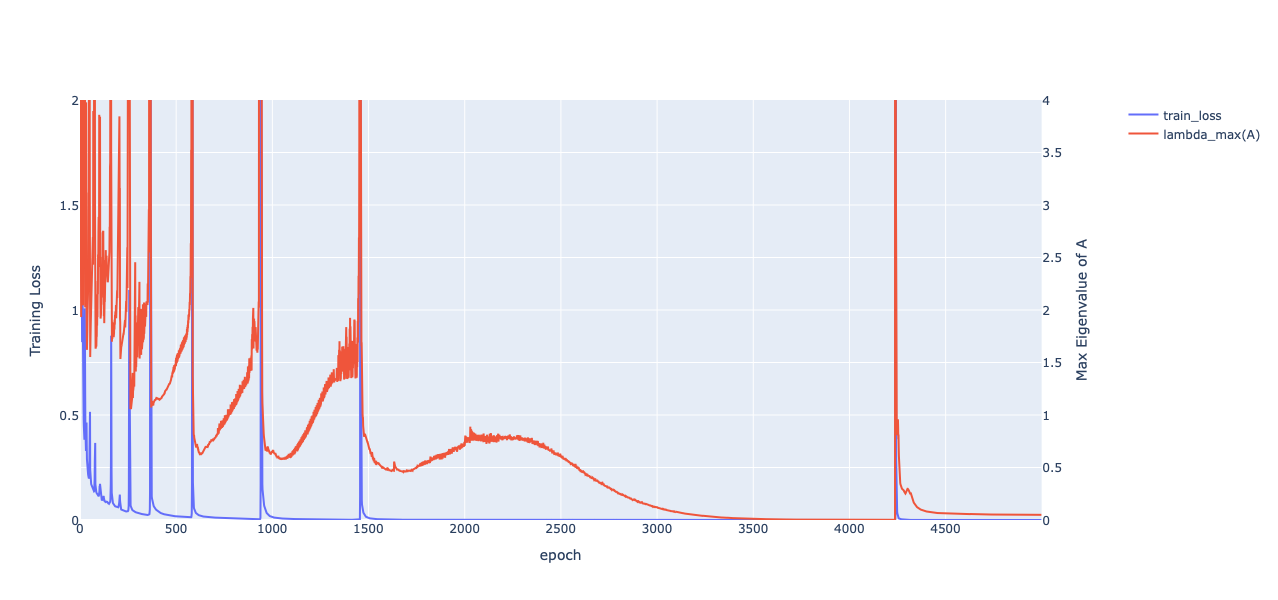

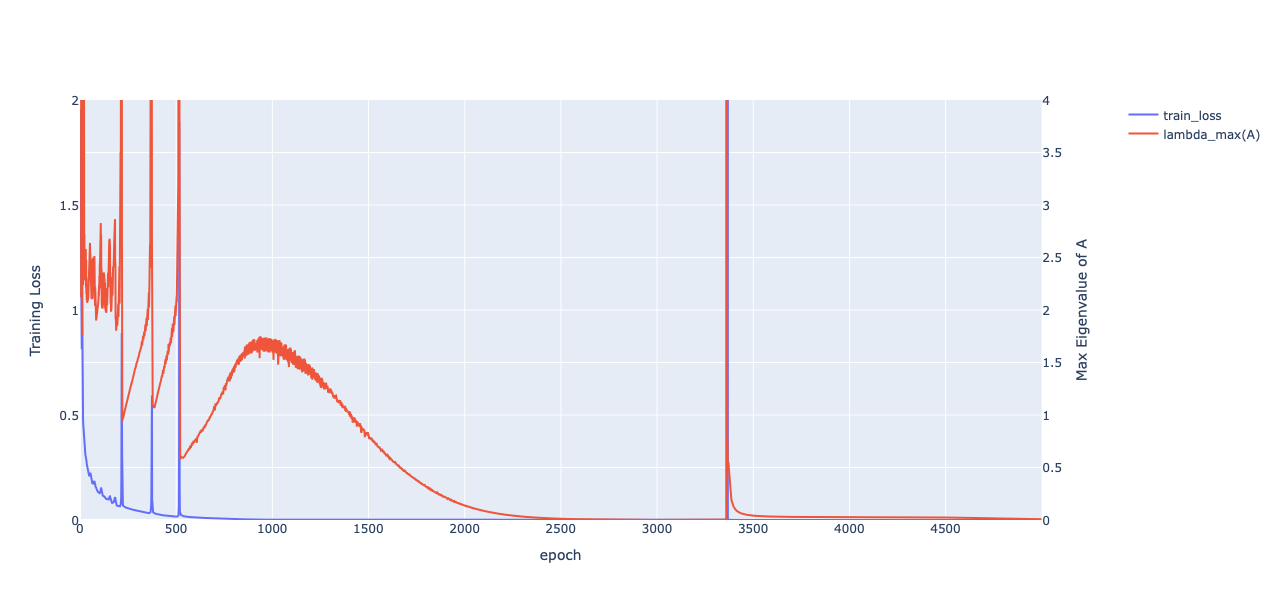

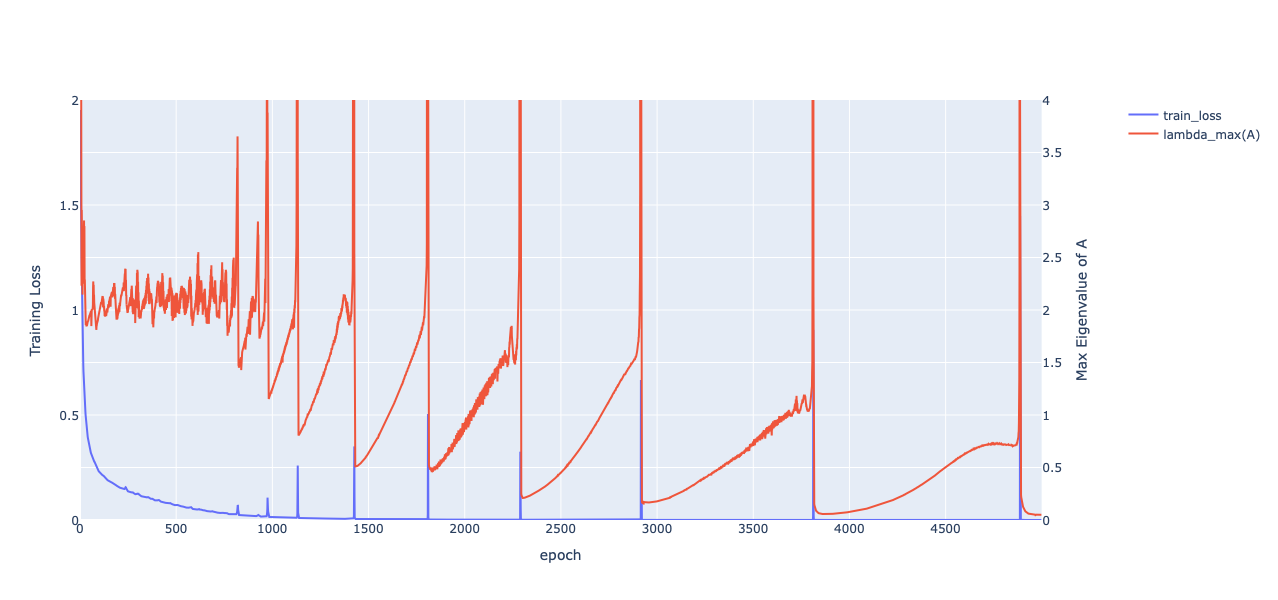

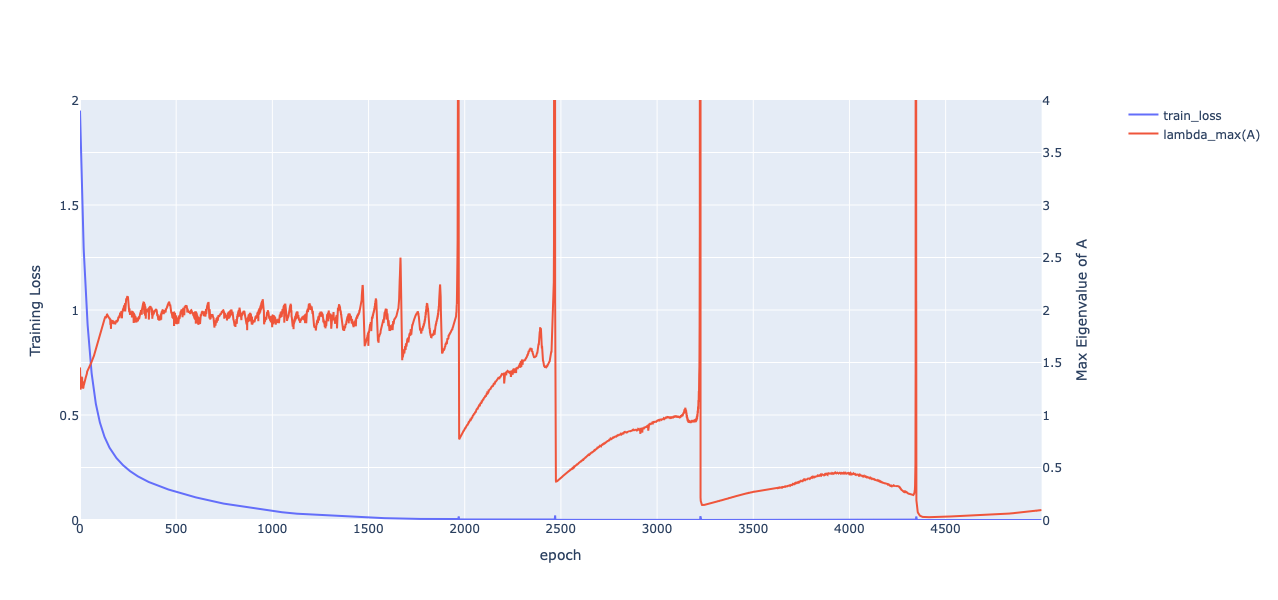

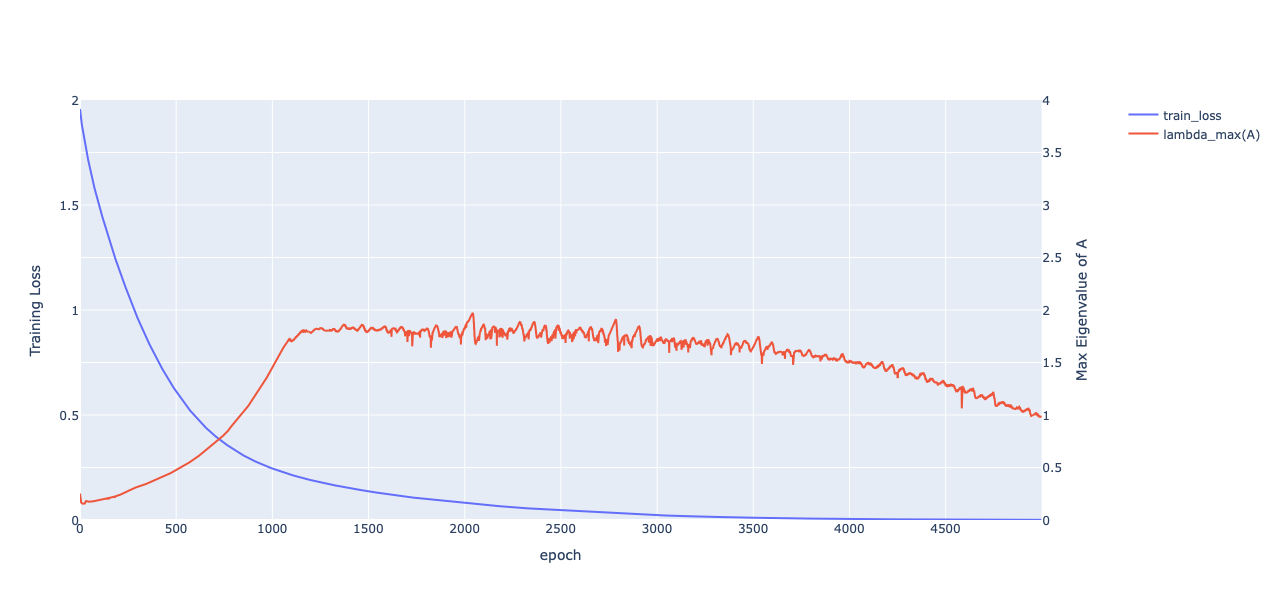

In [35]:
def plot_output_data(metadata, output, model_id):
    metadata = metadata[metadata['model_id']==model_id]
    output = output[output['model_id']==model_id]
    
    xs = np.arange(metadata['num_epochs'].iloc[0])
    losses = output['loss']
    sharpness = output['sharpness']
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(
        go.Scatter(x=xs, y=losses, name="train_loss",line=dict(width=2)),
        secondary_y=False
    )
    
    fig.add_trace(
        go.Scatter(x=xs, y=sharpness, name="lambda_max(A)", line=dict(width=2)),
        secondary_y=True
    )
    
    fig.update_yaxes(title_text="Training Loss", secondary_y=False, range = [0,2], showgrid=False)
    fig.update_yaxes(title_text="Max Eigenvalue of A", secondary_y=True, range = [0,4])
    fig.update_xaxes(title_text="epoch")
    fig.update_layout(height = 600, width = 1400)
    
    fig.show()

plot_output_data(md, out, 5)
plot_output_data(md, out, 6)
plot_output_data(md, out, 7)
plot_output_data(md, out, 8)
plot_output_data(md, out, 9)

In [30]:
model.eval()
with torch.no_grad():
    outputs = model(X_test.to(device))
    preds = outputs.argmax(dim=1)
    correct = (preds == y_test.to(device)).sum().item()
    accuracy = correct / len(y_test)

print(f"Test accuracy: {accuracy:.4f}")

NameError: name 'model' is not defined